# Outlier Detection with Autoencoders

In [1]:
import os
from datetime import datetime
from typing import Dict, List, Tuple
import warnings

import numpy as np
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms

C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Creating and Preprocessing the Data

### Loading the data

In [2]:
cardio_dict = scipy.io.loadmat('cardio.mat')

In [3]:
cardio_dict

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-18 10:48:09 UTC',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 0.00491231,  0.69319077, -0.20364049, ...,  0.23149795,
         -0.28978574, -0.49329397],
        [ 0.11072935, -0.07990259, -0.20364049, ...,  0.09356344,
         -0.25638541, -0.49329397],
        [ 0.21654639, -0.27244466, -0.20364049, ...,  0.02459619,
         -0.25638541,  1.14001753],
        ...,
        [-0.41835583, -0.91998844, -0.16463485, ..., -1.49268341,
          0.24461959, -0.49329397],
        [-0.41835583, -0.91998844, -0.15093411, ..., -1.42371616,
          0.14441859, -0.49329397],
        [-0.41835583, -0.91998844, -0.20364049, ..., -1.28578165,
          3.58465295, -0.49329397]]),
 'y': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])}

In [4]:
X = cardio_dict['X']
y = cardio_dict['y'].flatten()

### Data splitting

Divide the dataset into inliers and outliers:
- only inliers are used for trainig the autoencoders
- outliers are then mixed with the test set

In [5]:
X_inliers = X[y==0]
y_inliers = np.zeros(len(X_inliers), dtype=int)
X_outliers = X[y==1]
y_outliers = np.ones(len(X_outliers), dtype=int)
print(f'Number of inliers: {len(y_inliers)}, Number of outliers: {len(y_outliers)}')

Number of inliers: 1655, Number of outliers: 176


Split the inliers into training, validation, and testing set:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_inliers, y_inliers, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) # 0.25 x 0.8 = 0.2

Add outliers only to the test set

In [7]:
X_test = np.concatenate((X_test, X_outliers), axis=0)
y_test = np.concatenate((y_test, y_outliers), axis=0)

In [8]:
print(f'Training set: {len(y_train)} examples')
print(f'Validation set: {len(y_val)} examples')
print(f'Testing set: {len(y_test)} examples; inliers: {np.sum(y_test==0)}, outliers: {np.sum(y_test==1)}')

Training set: 1059 examples
Validation set: 265 examples
Testing set: 507 examples; inliers: 331, outliers: 176


In [9]:
display(X_train.shape)

(1059, 21)

### Creating Dataset and DataLoader instances

In [10]:
class CardioDataset(Dataset):
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.int32]:
        return self.data[idx], self.labels[idx]

In [11]:
train_data = CardioDataset(X_train, y_train)
val_data = CardioDataset(X_val, y_val)

In [12]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

## The Models

### 1. Undercomplete AutoEncoder

In [13]:
class UndercompleteAutoEncoder(nn.Module):
    def __init__(self):
        super(UndercompleteAutoEncoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(21, 16),
            nn.ReLU(),
            nn.Linear(16, 14),
            # nn.ReLU(),
            # nn.Linear(12, 10),
        )
        self.decode = nn.Sequential(
            # nn.Linear(10, 12),
            # nn.ReLU(),
            nn.Linear(14, 16),
            nn.ReLU(),
            nn.Linear(16, 21),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encode(x)
        x = self.decode(x)
        return x

In [14]:
undercomplete_ae = UndercompleteAutoEncoder()

learning_rate = 1e-2
optimizer = torch.optim.Adam(undercomplete_ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [15]:
def train_one_epoch(model: nn.Module):
    '''
    Train one epoch of the model on training dataset batched by the train_dataloader.
    
    :param nn.Module model: model on which we perform one training epoch
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs.float(), inputs.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_dataloader)

In [16]:
def train_model(model: nn.Module, model_name: str, nr_of_epochs: int = 100):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param int nr_of_epochs: number of training epochs
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch(model)
        model.eval()

        # performance on validation set
        valid_loss = 0.0
        for i, data in enumerate(val_dataloader):
            inputs, _ = data
            outputs = model(inputs.float())
            loss = criterion(outputs.float(), inputs.float())
            valid_loss += loss.item()
        valid_loss = valid_loss / len(val_dataloader)

        # logging at each Nth epoch
        if (epoch + 1) % 10 == 0:
            print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')
        
        # remember model with the best validation loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1

    # save the overall best model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('models/', exist_ok=True)
    model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
    torch.save(best_model, model_path)

In [17]:
train_model(model=undercomplete_ae, model_name='undercomplete_autoencoder', nr_of_epochs=200)

epoch 10; train loss: 0.10676610206856448; valid loss: 0.0886206716299057
epoch 20; train loss: 0.05410274162011988; valid loss: 0.044429348036646846
epoch 30; train loss: 0.04263077468118247; valid loss: 0.03406266048550606
epoch 40; train loss: 0.03481619531179175; valid loss: 0.02816076073795557
epoch 50; train loss: 0.030180597020422712; valid loss: 0.025487725995481013
epoch 60; train loss: 0.02889483268646633; valid loss: 0.024889564886689187
epoch 70; train loss: 0.029037740300683415; valid loss: 0.02512428741902113
epoch 80; train loss: 0.02448734131586902; valid loss: 0.02043268773704767
epoch 90; train loss: 0.02142066086697228; valid loss: 0.01772740464657545
epoch 100; train loss: 0.0202579560196575; valid loss: 0.01604881463572383
epoch 110; train loss: 0.01976293999263469; valid loss: 0.015702381357550622
epoch 120; train loss: 0.019982858506195685; valid loss: 0.01599363936111331
epoch 130; train loss: 0.02032640702365076; valid loss: 0.01629794528707862
epoch 140; train

In [18]:
def eval_on_testset(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.sum((reconstructed_test.detach() - testset_tensor) ** 2, axis=1)
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    display(error_df[error_df['class'] == 0].describe())
    display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [19]:
test_df, test_MSEs = eval_on_testset(undercomplete_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,1.056509,0.0
std,11.073931,0.0
min,0.024283,0.0
25%,0.138515,0.0
50%,0.214302,0.0
75%,0.428620,0.0
max,201.491638,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,17.162947,1.0
std,58.956360,0.0
min,0.107557,1.0
25%,0.772379,1.0
50%,2.331535,1.0
75%,8.066502,1.0
max,447.932312,1.0


In [20]:
def classify_by_error(MSEs: np.ndarray, thres: float) -> np.ndarray:
    '''
    Classify an array of reconstruction errors w.r.t. a threshold
    
    :param np.ndarray MSEs: mean squared reconstruction errors
    :param float thres: threshold of reconstruction error between inliers and outliers
    :returns: binary array of class ids; 0 = inlier, 1 = outlier
    '''
    return np.array(MSEs > thres, dtype=int)

In [21]:
def plot_confusion_matrix(confusion_mat: np.ndarray):
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray confusion_mat: confusion matrix between true and predicted labels
    '''
    class_labels = ['Inlier', 'Outlier']
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_mat, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt="d", annot_kws={"size": 14});
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [22]:
def try_threshold_grid(MSEs: np.ndarray, true_labels: np.ndarray, model_name: str, start: float = 0.0, stop: float = 5.0, num_thresholds: int = 10, verbose: bool = True) -> float:
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray MSEs: mean squared reconstruction errors on testing set
    :param np.ndarray true_labels: ground-truth labels
    :param str model_name: model name, e.g. denoising_autoencoder
    :param float start: start of threshold interval
    :param float stop: end of threshold interval
    :param int num_thresholds: number of thresholds tested in the interval
    :returns: threshold with the highest anomaly f1-score
    '''
    best_threshold = None
    best_f1 = 0.0
    display(Markdown(f'## Model: {model_name}, trying {num_thresholds} thresholds from [{start}, {stop}]'))
    if not verbose:
        display(Markdown('For more detail, call the method with `verbose=True`'))
        
    for threshold in np.linspace(start, stop, num=num_thresholds):
        predictions = classify_by_error(MSEs, threshold)
        matrix = confusion_matrix(true_labels, predictions)
        class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
        acc_df = pd.DataFrame({
            'Inliers Accuracy': [class_accuracies[0]], 
            'Outliers Accuracy': [class_accuracies[1]], 
            'Overall Accuracy': [accuracy_score(true_labels, predictions)]
        })
        
        outlier_f1 = f1_score(true_labels, predictions)
        if outlier_f1 > best_f1:
            best_f1 = outlier_f1
            best_threshold = threshold
        
        if verbose:
            display(Markdown(f'### Threshold {threshold}'))
            display(acc_df.style.hide_index())
            display(Markdown(f'##### Classification Report'))
            print(classification_report(true_labels, predictions))
            # plot_confusion_matrix(matrix)
            display(Markdown('---'))
    
    return best_threshold

In [23]:
optimal_threshold_under = try_threshold_grid(test_MSEs, y_test, 'undercomplete_autoencoder', start=0.1, stop=2.0, num_thresholds=40, verbose=False)

## Model: undercomplete_autoencoder, trying 40 thresholds from [0.1, 2.0]

For more detail, call the method with `verbose=True`

### Threshold 0.6358974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.845921,0.806818,0.832347


##### Classification Report

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       331
           1       0.74      0.81      0.77       176

    accuracy                           0.83       507
   macro avg       0.81      0.83      0.82       507
weighted avg       0.84      0.83      0.83       507



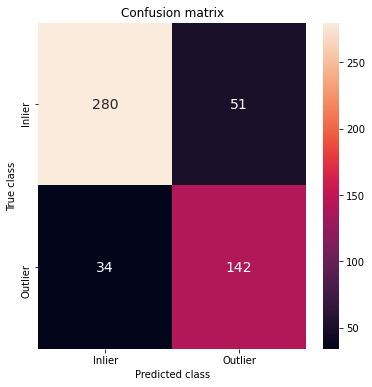

In [24]:
predictions = classify_by_error(test_MSEs, optimal_threshold_under)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Threshold {optimal_threshold_under}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

### 2. Denoising AutoEncoder

In [25]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, noise_rate):
        super(DenoisingAutoEncoder, self).__init__()
        self.noise_rate = noise_rate
        self.encode = nn.Sequential(
            nn.Linear(21, 16),
            nn.ReLU(),
            nn.Linear(16, 14),
        )
        self.decode = nn.Sequential(
            nn.Linear(14, 16),
            nn.ReLU(),
            nn.Linear(16, 21),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            # randn_like returns tensor the same shape as x with random numbers
            # from a normal distribution with mean 0 and variance 1
            x = x + torch.randn_like(x) * self.noise_rate
        x = self.encode(x)
        x = self.decode(x)
        return x

In [26]:
denoising_ae = DenoisingAutoEncoder(noise_rate=0.1)

learning_rate = 1e-2
optimizer = torch.optim.Adam(denoising_ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [27]:
train_model(model=denoising_ae, model_name='denoising_autoencoder', nr_of_epochs=200)

epoch 10; train loss: 0.10155428244787104; valid loss: 0.07641606852412224
epoch 20; train loss: 0.06683128633919884; valid loss: 0.05224263034760952
epoch 30; train loss: 0.04394382446566049; valid loss: 0.032374265044927596
epoch 40; train loss: 0.038372350199257624; valid loss: 0.028830742090940477
epoch 50; train loss: 0.03225989267230034; valid loss: 0.02389557510614395
epoch 60; train loss: 0.030717818833449307; valid loss: 0.021812247484922408
epoch 70; train loss: 0.029341391232960364; valid loss: 0.022216960974037647
epoch 80; train loss: 0.027138129424522903; valid loss: 0.02148634884506464
epoch 90; train loss: 0.026523892932078418; valid loss: 0.02106494698673487
epoch 100; train loss: 0.02579101186026545; valid loss: 0.021350991539657117
epoch 110; train loss: 0.0258773972882944; valid loss: 0.01973486766219139
epoch 120; train loss: 0.026417021146591974; valid loss: 0.02160129863768816
epoch 130; train loss: 0.025085257914136436; valid loss: 0.020028519816696642
epoch 140

In [28]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.994577,0.0
std,9.965929,0.0
min,0.035150,0.0
25%,0.139535,0.0
50%,0.219114,0.0
75%,0.442415,0.0
max,181.232117,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,13.675556,1.0
std,53.085487,0.0
min,0.084797,1.0
25%,0.912863,1.0
50%,1.788219,1.0
75%,3.322601,1.0
max,407.530762,1.0


In [29]:
optimal_threshold_denoising = try_threshold_grid(test_MSEs, y_test, 'denoising_autoencoder', start=0.1, stop=2.0, num_thresholds=40, verbose=False)

## Model: denoising_autoencoder, trying 40 thresholds from [0.1, 2.0]

For more detail, call the method with `verbose=True`

### Threshold 0.6846153846153846

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.854985,0.852273,0.854043


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       331
           1       0.76      0.85      0.80       176

    accuracy                           0.85       507
   macro avg       0.84      0.85      0.84       507
weighted avg       0.86      0.85      0.86       507



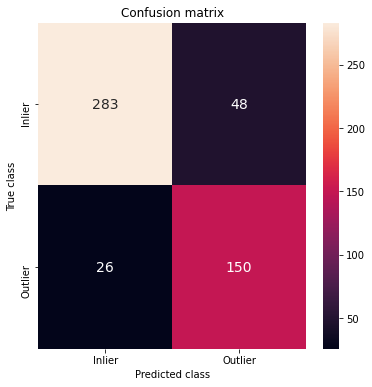

In [30]:
predictions = classify_by_error(test_MSEs, optimal_threshold_denoising)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Threshold {optimal_threshold_denoising}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

### 3. Variational AutoEncoder

In [31]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encLin1 = nn.Linear(21, 16)
        self.reluEnc = nn.ReLU()
        self.encLin21 = nn.Linear(16, 14)
        self.encLin22 = nn.Linear(16, 14)
        self.normal = torch.distributions.Normal(0, 1)
        self.kl = 0
        
        self.decLin1 = nn.Linear(14, 16)
        self.reluDec = nn.ReLU()
        self.decLin2 = nn.Linear(16, 21)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.reluEnc(self.encLin1(x))
        mu = self.encLin21(x)
        sigma = torch.exp(self.encLin22(x))
        z = mu + sigma * self.normal.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()

        x = self.reluDec(self.decLin1(z))
        x = self.decLin2(x)
        return x

In [32]:
variational_ae = VariationalAutoEncoder()

learning_rate = 1e-2
optimizer = torch.optim.Adam(variational_ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [33]:
def train_one_epoch_VAE(model: nn.Module):
    '''
    Train one epoch of the model on training dataset batched by the train_dataloader.
    
    :param nn.Module model: model on which we perform one training epoch
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_dataloader)

In [34]:
def train_model_VAE(model: nn.Module, model_name: str, nr_of_epochs: int = 100):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param int nr_of_epochs: number of training epochs
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch_VAE(model)
        model.eval()

        # performance on validation set
        with torch.no_grad():
            valid_loss = 0.0
            for i, data in enumerate(val_dataloader):
                inputs, _ = data
                outputs = model(inputs.float())
                loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
                valid_loss += loss.item()
            valid_loss = valid_loss / len(val_dataloader)

            # logging at each Nth epoch
            if (epoch + 1) % 10 == 0:
                print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')

            # remember model with the best validation loss
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = model.state_dict()
                best_epoch = epoch + 1

    # save the overall best model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('models/', exist_ok=True)
    model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
    torch.save(best_model, model_path)

In [35]:
train_model_VAE(model=variational_ae, model_name='variational_autoencoder', nr_of_epochs=200)

epoch 10; train loss: 0.9659566633841571; valid loss: 0.9560488224029541
epoch 20; train loss: 0.9393704954315635; valid loss: 0.9250406384468078
epoch 30; train loss: 0.9301898935261894; valid loss: 0.921835196018219
epoch 40; train loss: 0.9223753529436448; valid loss: 0.8964506149291992
epoch 50; train loss: 0.9157992531271542; valid loss: 0.9108871340751648
epoch 60; train loss: 0.9186567348592422; valid loss: 0.9070075273513794
epoch 70; train loss: 0.9135943616137785; valid loss: 0.9113649725914001
epoch 80; train loss: 0.9095214394962087; valid loss: 0.9099403500556946
epoch 90; train loss: 0.9044888650669771; valid loss: 0.9021581768989563
epoch 100; train loss: 0.9109630619778353; valid loss: 0.9122466921806336
epoch 110; train loss: 0.9040594241198372; valid loss: 0.8929771423339844
epoch 120; train loss: 0.8924074874204748; valid loss: 0.9012478351593017
epoch 130; train loss: 0.8920509254231173; valid loss: 0.889958655834198
epoch 140; train loss: 0.8901181922239416; valid 

In [36]:
def eval_on_testset_VAE(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.mean((reconstructed_test.detach() - testset_tensor) ** 2, axis=1) + model.kl
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    display(error_df[error_df['class'] == 0].describe())
    display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [37]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.994577,0.0
std,9.965929,0.0
min,0.035150,0.0
25%,0.139535,0.0
50%,0.219114,0.0
75%,0.442415,0.0
max,181.232117,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,13.675556,1.0
std,53.085487,0.0
min,0.084797,1.0
25%,0.912863,1.0
50%,1.788219,1.0
75%,3.322601,1.0
max,407.530762,1.0


In [38]:
optimal_threshold_vae = try_threshold_grid(test_MSEs, y_test, 'variational_autoencoder', start=0.1, stop=2.0, num_thresholds=40, verbose=False)

## Model: variational_autoencoder, trying 40 thresholds from [0.1, 2.0]

For more detail, call the method with `verbose=True`

### Threshold 0.6846153846153846

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.854985,0.852273,0.854043


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       331
           1       0.76      0.85      0.80       176

    accuracy                           0.85       507
   macro avg       0.84      0.85      0.84       507
weighted avg       0.86      0.85      0.86       507



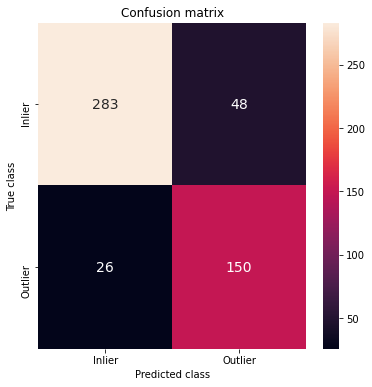

In [39]:
predictions = classify_by_error(test_MSEs, optimal_threshold_vae)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Threshold {optimal_threshold_vae}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

## Final Remarks

I have compared three different autoencoder architectures for outlier detection:
1. undercomplete autoencoder
2. denoising autoencoder
3. variational autoencoder

For each of them, I tuned the following hyperparameters:
- learning rate
- batch size
- number of layers and their width (most importantly the size of the latent space)
- threshold for reconstruction error

I have chosen the best classifier based on the F1-score, where negative class is composed of inliers and positive class is composed of outliers.

Below, you can find the best hyper-parameters of the architectures. As for the layers, only encoder architecture is shown, since decoder contains the same layers reversed.

In [40]:
result_df = pd.DataFrame({'Architecture': ['Undercomplete Autoencoder', 'Denoising Autoencoder', 'Variational Autoencoder'],
                          'Learning Rate': [1e-2, 1e-2, 1e-2],
                          'Batch Size': [64, 64, 64], 
                          'Architecture Encoder': [
                              'Linear(21, 16) → ReLU → Linear(16, 14)', 'Linear(21, 16) → ReLU → Linear(16, 14)', 'Linear(21, 16) → ReLU → Linear(16, 14)'
                          ],
                          'Latent Space Size': [14, 14, 14],
                          'Reconstruction MSE Threshold': [optimal_threshold_under, optimal_threshold_denoising, optimal_threshold_vae],
                         })
result_df = result_df.set_index('Architecture')
display(result_df)

,Learning Rate,Batch Size,Architecture Encoder,Latent Space Size,Reconstruction MSE Threshold
Architecture,,,,,
Undercomplete Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.635897
Denoising Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.684615
Variational Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.684615
